In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda:1')

torch.manual_seed(121)

In [ ]:
class PIRBN_1D(nn.Module):

    def __init__(self, centers, b_init=1.0, dtype=torch.float64):

        super().__init__()
        self.dtype = dtype

        self.register_buffer('centers', centers.to(dtype))
        self.N = centers.shape[0]

        self.b = nn.Parameter(b_init * torch.ones(1, self.N, dtype=dtype))  
        self.a = nn.Parameter(torch.randn(self.N, 1, dtype=dtype))          
        self.bias = nn.Parameter(torch.randn(1, dtype=dtype))                     

    def forward(self, t):

        t_exp = t.unsqueeze(1)           
        c_exp = self.centers.unsqueeze(0)  

        dist_sq = torch.sum((t_exp - c_exp)**2, dim=2)

        rbf = torch.exp(-self.b**2 * dist_sq)  

        u = torch.matmul(rbf, self.a) + self.bias       
        return u


    def utt(self, t):
        
        t = t.clone().detach().requires_grad_(True)
        u = self.forward(t)
        grad1 = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]          
        grad2 = torch.autograd.grad(
            grad1, t,
            grad_outputs=torch.ones_like(grad1),
            create_graph=True
        )[0]          
        return u, grad1, grad2


In [3]:
# Parameters
e = torch.tensor(2**-7, dtype=torch.float64, device=device)

def analytical(t):
    return t**2 + 2 - torch.exp(-t/e)

def right_side(t):
    expo = torch.exp(-t/e)
    res = (2 - expo + t**2)**2 + (3 + t)*(2*t + expo/e) + e*(2 - expo/e**2) - torch.sin(2 - expo + t**2)
    return res


In [ ]:
Nt = 64
tcenters = torch.linspace(-0.2, 1.2, Nt, dtype=torch.float64)
centers = torch.stack([tcenters, torch.zeros_like(tcenters)], dim=1).to(device)

Ncolloc = 1024
tcolloc = torch.rand(Ncolloc, 1, dtype=torch.float64).to(device)        

Nic = 128
tic = torch.zeros(Nic, 1, dtype=torch.float64).to(device)

t_validate = torch.rand(1000, 1, dtype=torch.float64, device=device)


In [ ]:
model = PIRBN_1D(centers, b_init=5.0, dtype=torch.float64).to(device)

print(f"PIRBN has {sum(p.numel() for p in model.parameters()):,} parameters")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10**5
print_interval = 10**3

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.9)   



PIRBN has 129 parameters


In [ ]:
def loss_print(pde_loss, ic_loss, model, epoch):
    with torch.no_grad():           
        u_pred_validate = model(t_validate)
        u_exact_validate = analytical(t_validate)
        l2_error = torch.sqrt(torch.mean((u_pred_validate - u_exact_validate)**2)) / \
                    torch.sqrt(torch.mean(u_exact_validate**2))
    
    print(f"\n Epoch {epoch:6d} | "
            f"PDE: {pde_loss.item():.2e} | BC: {ic_loss.item():.2e} | "
            f"L2_rel: {l2_error.item():.2e}")
     



def loss(model):

    u, ut, utt = model.utt(tcolloc)
    f = right_side(tcolloc)
    res = e*utt + (3.0 + tcolloc)*ut + u**2 - torch.sin(u) - f
    pde_loss = torch.mean(res**2)

    u0, ut0, _ = model.utt(tic)
    ic1 = torch.mean((u0 - 1.0)**2)      # u(0) = 1
    ic2 = torch.mean((ut0 - 1.0/e)**2)   # u'(0) = 1/eps
    ic_loss = ic1 + ic2

    total = pde_loss + ic_loss

    return total, pde_loss, ic_loss
       


In [ ]:
global itr
itr = 0

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 10**5

for epoch in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()
    total_loss, pde_loss, ic_loss = loss(model)

    total_loss.backward()
    optimizer.step()
    
    if epoch % print_interval == 0: 
         loss_print(pde_loss, ic_loss, model, epoch)

  1%|          | 1044/100000 [00:08<07:21, 223.98it/s]


 Epoch   1000 | PDE: 4.60e+02 | BC: 1.48e+04 | L2_rel: 1.21e+00


  2%|▏         | 2026/100000 [00:13<06:39, 245.48it/s]


 Epoch   2000 | PDE: 4.52e+02 | BC: 1.46e+04 | L2_rel: 1.19e+00


  3%|▎         | 3008/100000 [00:21<12:54, 125.25it/s]


 Epoch   3000 | PDE: 4.45e+02 | BC: 1.44e+04 | L2_rel: 1.18e+00


  4%|▍         | 4036/100000 [00:32<08:45, 182.60it/s]


 Epoch   4000 | PDE: 4.40e+02 | BC: 1.42e+04 | L2_rel: 1.16e+00


  5%|▌         | 5033/100000 [00:37<07:54, 200.32it/s]


 Epoch   5000 | PDE: 4.36e+02 | BC: 1.40e+04 | L2_rel: 1.15e+00


  6%|▌         | 6018/100000 [00:43<14:15, 109.85it/s]


 Epoch   6000 | PDE: 4.33e+02 | BC: 1.37e+04 | L2_rel: 1.13e+00


  7%|▋         | 7032/100000 [00:49<06:51, 225.87it/s]


 Epoch   7000 | PDE: 4.32e+02 | BC: 1.35e+04 | L2_rel: 1.12e+00


  8%|▊         | 8004/100000 [00:54<07:01, 218.18it/s]


 Epoch   8000 | PDE: 4.32e+02 | BC: 1.33e+04 | L2_rel: 1.10e+00


  9%|▉         | 9021/100000 [00:59<06:23, 237.21it/s]


 Epoch   9000 | PDE: 4.33e+02 | BC: 1.31e+04 | L2_rel: 1.09e+00


 10%|█         | 10042/100000 [01:04<06:57, 215.55it/s]


 Epoch  10000 | PDE: 4.36e+02 | BC: 1.29e+04 | L2_rel: 1.08e+00


 11%|█         | 11013/100000 [01:11<06:22, 232.34it/s]


 Epoch  11000 | PDE: 4.40e+02 | BC: 1.27e+04 | L2_rel: 1.06e+00


 12%|█▏        | 12043/100000 [01:18<07:50, 186.84it/s]


 Epoch  12000 | PDE: 4.45e+02 | BC: 1.25e+04 | L2_rel: 1.05e+00


 13%|█▎        | 13025/100000 [01:24<05:46, 251.35it/s]


 Epoch  13000 | PDE: 4.52e+02 | BC: 1.23e+04 | L2_rel: 1.03e+00


 14%|█▍        | 14034/100000 [01:29<06:59, 205.16it/s]


 Epoch  14000 | PDE: 4.60e+02 | BC: 1.21e+04 | L2_rel: 1.02e+00


 15%|█▌        | 15017/100000 [01:34<07:11, 196.77it/s]


 Epoch  15000 | PDE: 4.69e+02 | BC: 1.19e+04 | L2_rel: 1.01e+00


 16%|█▌        | 16013/100000 [01:40<05:58, 234.08it/s]


 Epoch  16000 | PDE: 4.80e+02 | BC: 1.17e+04 | L2_rel: 9.92e-01


 17%|█▋        | 17030/100000 [01:45<05:36, 246.36it/s]


 Epoch  17000 | PDE: 4.92e+02 | BC: 1.15e+04 | L2_rel: 9.79e-01


 18%|█▊        | 18010/100000 [01:53<15:46, 86.65it/s] 


 Epoch  18000 | PDE: 5.05e+02 | BC: 1.13e+04 | L2_rel: 9.66e-01


 19%|█▉        | 19042/100000 [01:58<05:29, 245.99it/s]


 Epoch  19000 | PDE: 5.19e+02 | BC: 1.11e+04 | L2_rel: 9.52e-01


 20%|██        | 20012/100000 [02:04<14:26, 92.31it/s] 


 Epoch  20000 | PDE: 5.35e+02 | BC: 1.09e+04 | L2_rel: 9.39e-01


 21%|██        | 21034/100000 [02:11<05:25, 242.54it/s]


 Epoch  21000 | PDE: 5.52e+02 | BC: 1.07e+04 | L2_rel: 9.26e-01


 22%|██▏       | 22009/100000 [02:19<14:20, 90.64it/s] 


 Epoch  22000 | PDE: 5.70e+02 | BC: 1.05e+04 | L2_rel: 9.14e-01


 23%|██▎       | 23011/100000 [02:26<14:21, 89.41it/s] 


 Epoch  23000 | PDE: 5.89e+02 | BC: 1.04e+04 | L2_rel: 9.01e-01


 24%|██▍       | 24033/100000 [02:36<09:14, 136.93it/s]


 Epoch  24000 | PDE: 6.10e+02 | BC: 1.02e+04 | L2_rel: 8.88e-01


 25%|██▌       | 25017/100000 [02:47<13:30, 92.53it/s] 


 Epoch  25000 | PDE: 6.31e+02 | BC: 9.99e+03 | L2_rel: 8.76e-01


 26%|██▌       | 26036/100000 [02:55<05:07, 240.29it/s]


 Epoch  26000 | PDE: 6.53e+02 | BC: 9.81e+03 | L2_rel: 8.64e-01


 27%|██▋       | 27011/100000 [03:00<11:38, 104.48it/s]


 Epoch  27000 | PDE: 6.75e+02 | BC: 9.64e+03 | L2_rel: 8.51e-01


 28%|██▊       | 28016/100000 [03:11<13:16, 90.35it/s] 


 Epoch  28000 | PDE: 6.97e+02 | BC: 9.46e+03 | L2_rel: 8.38e-01


 29%|██▉       | 29029/100000 [03:20<04:34, 258.19it/s]


 Epoch  29000 | PDE: 7.19e+02 | BC: 9.29e+03 | L2_rel: 8.26e-01


 30%|███       | 30033/100000 [03:26<04:30, 258.39it/s]


 Epoch  30000 | PDE: 7.42e+02 | BC: 9.12e+03 | L2_rel: 8.14e-01


 31%|███       | 31015/100000 [03:35<12:34, 91.39it/s] 


 Epoch  31000 | PDE: 7.66e+02 | BC: 8.95e+03 | L2_rel: 8.01e-01


 32%|███▏      | 32009/100000 [03:44<12:51, 88.14it/s] 


 Epoch  32000 | PDE: 7.92e+02 | BC: 8.78e+03 | L2_rel: 7.90e-01


 33%|███▎      | 33001/100000 [03:53<04:46, 233.50it/s]


 Epoch  33000 | PDE: 8.19e+02 | BC: 8.61e+03 | L2_rel: 7.79e-01


 34%|███▍      | 34012/100000 [04:04<12:35, 87.40it/s] 


 Epoch  34000 | PDE: 8.46e+02 | BC: 8.45e+03 | L2_rel: 7.68e-01


 35%|███▌      | 35015/100000 [04:12<08:42, 124.27it/s]


 Epoch  35000 | PDE: 8.75e+02 | BC: 8.29e+03 | L2_rel: 7.57e-01


 36%|███▌      | 36014/100000 [04:18<05:37, 189.77it/s]


 Epoch  36000 | PDE: 9.03e+02 | BC: 8.13e+03 | L2_rel: 7.47e-01


 37%|███▋      | 37031/100000 [04:24<04:14, 247.06it/s]


 Epoch  37000 | PDE: 9.32e+02 | BC: 7.97e+03 | L2_rel: 7.37e-01


 37%|███▋      | 37499/100000 [04:26<07:23, 140.93it/s]


KeyboardInterrupt: 

Relative L2 error: 1.16e-01


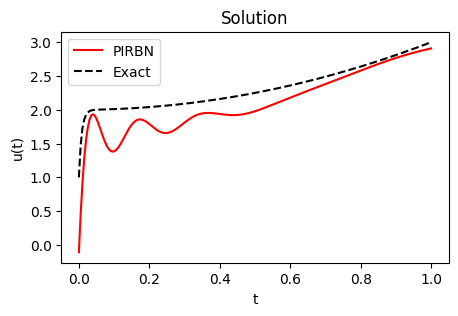

In [ ]:
N_eval = 200
t_eval = torch.linspace(0.0, 1.0, N_eval, dtype=torch.float64, device=device).unsqueeze(1)

with torch.no_grad():
    u_pred_torch = model(t_eval)              # (N_eval, 1)
    u_exact_torch = analytical(t_eval)        # (N_eval, 1)

u_pred = u_pred_torch.cpu().numpy().ravel()
u_exact = u_exact_torch.cpu().numpy().ravel()
t_eval_np = t_eval.cpu().numpy().ravel()

l2_error = np.sqrt(np.mean((u_pred - u_exact)**2)) / np.sqrt(np.mean(u_exact**2))
print(f"Relative L2 error: {l2_error:.2e}")



plt.figure(figsize=(5, 3))

plt.plot(t_eval_np, u_pred, 'r-', label='PIRBN')
plt.plot(t_eval_np, u_exact, 'k--', label='Exact')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Solution')
plt.legend()



plt.show()

